# Topic Modeling for Finding Table Titles Relevant to Drug-Adverse Events

- The following codes is implemented for topic modeling through LDA in attempt to find document samples(table title data) relevant to drug and adverse events.
- Topic modeling is one of statistical modeling for discovering the abstract 'topics' that occur in a collection of document.
 - An example of topic model is used to classify text in a document to a particular topic
 - it builds a topic per document model and words per topic model, modeled as Dirichlet distributions
- Following urls and research articles were referenced.
 - https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
 - http://www.engear.net/wp/topic-modeling-gensimpython/
 - https://markroxor.github.io/gensim/static/notebooks/lda_training_tips.html
 - https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore
 - https://markroxor.github.io/gensim/static/notebooks/lda_training_tips.html
 - http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb
 - http://jeriwieringa.com/2018/07/17/pyLDAviz-and-Mallet/#comment-4018495276
 - https://ldavis.cpsievert.me/reviews/reviews.html
 - https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

### Latent Dirichlet Allocation

#### Data Retrival

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import re
pd.set_option('display.max_colwidth', -1)

In [3]:
#retrieve table titles from csv
data = pd.read_csv('../data/titles_condition_by_t.tsv', delimiter='\t', header=None)
# data = pd.read_csv('titles_no_replace.tsv', delimiter='\t', error_bad_lines=True, header=None)
data.columns = ['id', 'title']

In [4]:
data.shape

(32050, 2)

In [5]:
data.loc[data.title.isna()]

,id,title
31295,50229,NaN


In [6]:
data.title = data.title.str.strip()
documents = data

In [7]:
documents['title'].replace('', np.nan, inplace=True)
print('checking if text is missing')
print(documents.isna().any())
documents.shape

checking if text is missing
id       False
title    True 
dtype: bool


(32050, 2)

In [8]:
documents.head()

,id,title
0,4106,Analysis of efficacy
1,4107,Comparisons of postoperative CA19-9 levels on survival of ESPAC-4 with the CONOKO-01 and JASPAC-1 trials
2,4108,Pattern of disease relapse
3,4109,Grade 1–5 adverse events with gemcitabine alone and gemcitabine plus capecitabine
4,4112,Treatment with zoledronic acid


In [9]:
documents.dropna(subset=['title'], inplace=True)
documents = documents.reset_index()
print(documents.isna().any())
documents.shape

index    False
id       False
title    False
dtype: bool


(32049, 3)

In [10]:
documents = documents.astype(str)

In [11]:
documents.loc[documents.title.str.split(' ').apply(lambda x: len(x)) < 2]

,index,id,title
209,209,4418,Morphometry
300,300,4556,Outcomes
798,798,5354,Echocardiography
1075,1075,5784,Procedures
1095,1095,5810,Hemodynamics
1186,1186,6299,Outcomes
1442,1442,6679,Side-effects
1883,1883,7339,Complications
2238,2238,7922,Outcomes
2332,2332,8084,Results


In [12]:
# rep = {'nbsp':'', 'table':'', 'legend':'', 'mg/dl':'', 'g/l':'', 'yrs':'year', '\n':' ', ';':'', 'kg/m2':'', 'n=':''}
rep = {'nbsp':'', 'table':'', 'legend':'', 'yrs':'year', '\n':' '}
# clean_content = [pattern.sub(lambda m: rep[re.escape(m.group(0))], x['content']) for x in train_data]
rep = dict((re.escape(k), v) for k, v in rep.items())
pattern = re.compile("|".join(rep.keys()))
documents.title = [pattern.sub(lambda m: rep[re.escape(m.group(0))], str(x)) for x in documents.title]

#### Data Pre-processing
- tokenization : 
  - split the text into sentences and then sentences into words
  - lower case words
  - remove punctuation
  - remove words with fewer than 2 characters
  - remove all stopwords + added ('table', 'legend')
- Lemmatization : 
 - verbs in past and future tenses are changed into present
- Stemmazation :
 - words are reduced to their root form

In [13]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.parsing.preprocessing import strip_numeric
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

In [14]:
np.random.seed(2018)

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/grace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
stemmer = SnowballStemmer('english')
STOP_WORDS = list(gensim.parsing.preprocessing.STOPWORDS)
STOP_WORDS.extend(['table', 'legend'])

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
#     deacc=True removes punctuations
    for token in gensim.utils.simple_preprocess(text, deacc=True):
        if token not in STOP_WORDS and len(token)>1:
#             result.append(lemmatize_stemming(strip_numeric(token)))
            result.append(lemmatize_stemming(token))
    return result

In [16]:
%%time
#process the text, save the results as processed_docs
processed_docs = pd.DataFrame()
processed_docs = pd.concat([documents.id, documents.title.map(preprocess)], axis=1)
processed_docs[:5]

CPU times: user 17.5 s, sys: 317 ms, total: 17.8 s
Wall time: 29.4 s


- Trigram model : implement n-grams with Gensim Phrases

In [17]:
# %%time
# #min_count = ignore all words and bigrams with total collected count lower than this value
# #threshold = represent a score threshold for forming the phrases(higher means fewer phrases)
# bigram = gensim.models.Phrases(processed_docs.title, min_count=1, threshold=0.3)
# trigram = gensim.models.Phrases(bigram[processed_docs.title], threshold=0.3)

# #sentence clubbed as a trigram/bigram
# bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

In [18]:
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

In [19]:
def make_bigram(text):
    processed_text = [[word for word in simple_preprocess(str(doc)) if word not in STOP_WORDS] for doc in text]
    return [bigram_mod[doc] for doc in processed_text]

def make_trigram(text):
    processed_text = [[word for word in simple_preprocess(str(doc)) if word not in STOP_WORDS] for doc in text]
    return trigram_mod[[bigram_mod[doc] for doc in processed_text]]

def explain_make_trigram(text):
    conversion = {}
    for doc in text:
        pro_doc = simple_preprocess(str(doc))
        if doc!= pro_doc:
            print(doc)
            print(pro_doc)
            conversion[doc]=pro_doc
    return conversion

def n_gram_lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    text_out = []
    for sent in text:
        doc = nlp(' '.join(sent))
        text_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return text_out

def explain_n_gram_lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    conversions = {}
    for sent in text:
        doc = nlp(' '.join(sent))
        for token in doc:
            if len(token.lemma_) <4 and str(token)!=str(token.lemma_):
                conversions[token] = token.lemma_
#                 print('%s : %s' (token, token.lemma_))
    return conversions

In [20]:
# %%time
# processed_bigram = n_gram_lemmatization(make_bigram(processed_docs.title))
# processed_trigram = n_gram_lemmatization(make_trigram(processed_docs.title))
# print(str(len(processed_bigram)))
# print(str(len(processed_trigram)))
# processed_docs['bigram'] = processed_bigram
# processed_docs['trigram'] = processed_trigram
# processed_docs.head(10)

### bag of words on the data set
- create a dictionary from 'processed_docs' containing the number of times a word appears in the training set

In [21]:
#############
dictionary_made_by = processed_docs.title
dictionary_made_by_str = 'unigram'#'bigram'#'trigram'

dictionary = gensim.corpora.Dictionary(dictionary_made_by)
print('size of the dictionary %d' %len(dictionary))
max_dic_size = len(dictionary)
# test_dic_sizes = [max_dic_size, int(max_dic_size*2/3), int(max_dic_size/2), 10000]
# test_dic_sizes = [8000, 7000, int(max_dic_size*2/3), int(max_dic_size/2), 6000, 10000]
test_dic_sizes = [6000]

size of the dictionary 10383


In [22]:
# filter out tokens that appear in less than 0.05 documents 
# or more than 0.5 documents
# after above, keep only the first 40000 most frequent tokens.

#############
dict_size = test_dic_sizes[0]
dictionary.filter_extremes(no_below=0.08, no_above=0.8, keep_n=dict_size)

In [23]:
# vectorize
# Bag-of-words representation of the documents
bow_corpus = [dictionary.doc2bow(doc) for doc in dictionary_made_by]

bow_doc_100 = bow_corpus[100]
for i in range(len(bow_doc_100)):
    print("Word {} (\"{}\") appears {} times.".format(bow_doc_100[i][0],
                                                     dictionary[bow_doc_100[i][0]],
                                                     bow_doc_100[i][1]))

processed_docs['bow_corpus'] = bow_corpus
processed_docs.head(10)

Word 85 ("risk") appears 1 times.
Word 242 ("assess") appears 1 times.
Word 319 ("noninvas") appears 1 times.


,id,title,bow_corpus
0,4106,"[analysi, efficaci]","[(0, 1), (1, 1)]"
1,4107,"[comparison, postop, ca, level, surviv, espac, conoko, jaspac, trial]","[(2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]"
2,4108,"[pattern, diseas, relaps]","[(8, 1), (9, 1), (10, 1)]"
3,4109,"[grade, advers, event, gemcitabin, gemcitabin, plus, capecitabin]","[(11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]"
4,4112,"[treatment, zoledron, acid]","[(16, 1), (17, 1), (18, 1)]"
5,4113,"[treatment, docetaxel]","[(17, 1), (19, 1)]"
6,4114,"[treatment, relaps, discret, treat, clinician]","[(10, 1), (17, 1), (20, 1), (21, 1), (22, 1)]"
7,4115,"[worst, advers, event, grade, report, entir, time, trial]","[(7, 1), (11, 1), (13, 1), (14, 1), (23, 1), (24, 1), (25, 1), (26, 1)]"
8,4117,"[chemotherapi, deliveri, trial, drug, discontinu]","[(7, 1), (27, 1), (28, 1), (29, 1), (30, 1)]"
9,4118,"[advers, event]","[(11, 1), (13, 1)]"


In [24]:
processed_docs.shape

(32049, 3)

#### TF-IDF
- tf-idf model on bow_corpus

- tf = count(word, document) / len(document)
- idf = log( len(collection) / count(document_containing_term, collection)
- tf-idf = tf * idf

In [25]:
from gensim import corpora, models
from pprint import pprint

# tfidf_mod = models.TfidfModel(bow_corpus)
# tfidf_corpus = tfidf_mod[bow_corpus]

# processed_docs['tfidf_corpus'] = tfidf_corpus
# tfidf_doc_100 = tfidf_corpus[100]
# for i in range(len(tfidf_doc_100)):
#     print("Word {} (\"{}\") appears {} times.".format(tfidf_doc_100[i][0],
#                                                      dictionary[tfidf_doc_100[i][0]],
#                                                      tfidf_doc_100[i][1]))

In [26]:
# print('Number of unique tokens: %d' % len(dictionary))
# print('Number of documents bow corpus: %d' % len(bow_corpus))
# print('Number of documents tfidf: %d' % len(tfidf_corpus))
# print('Number of documents : %d' % len(dictionary_made_by))

#### Optimal number of topics
- build many LDA models with different values of number of topics and pick the one that gives the highest coherence value based on corpus
- 토픽 모델링 결과로 나온 주제들에 대해 각각의 주제에서 상위 N개의 단어를 뽑습니다. 모델링이 잘 되었을수록 한 주제 안에는 의미론적으로 유사한 단어가 많이 모여있게 마련입니다. 따라서 상위 단어 간의 유사도를 계산하면 실제로 해당 주제가 의미론적으로 일치하는 단어들끼리 모여있는지 알 수 있습니다.

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# def compute_coherence_values(model_type, dictionary, corpus, texts, limit, start=2, step=3):
#     """
#     compute c_v coherence for various number of topics
    
#     parameters:
#     dictionary : gensim dictionary
#     corpus : gensim corpus
#     texts : list of input texts
#     limit : max number of topics
    
#     returns:
#     model_list : list of LDA topic models
#     coherence_values : coherence value
#     """
    
#     coherenece_values = []
#     u_mass_coherenece_values = []
#     model_list = []
#     for num_topics in range(start, limit, step):
#         if model_type == 'mallet':
#             model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, \
#                                                      num_topics=num_topics, \
#                                                      id2word=dictionary, workers=8, \
#                                                      iterations=60)
#         elif model_type == 'online':
#             model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, \
#                                                     num_topics=num_topics, update_every=0, \
#                                                     passes=20)
#         else:
#             model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, \
#                                                id2word=dictionary, passes=2, \
#                                                workers=8, iterations=60)
        
#         model_list.append(model)
#         coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
#         u_mass_coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        
#         coherenece_values.append(coherence_model.get_coherence())
#         u_mass_coherenece_values.append(u_mass_coherence_model.get_coherence())

#     return model_list, coherenece_values, u_mass_coherenece_values

# def find_optimal_topic_num(model_type, model_list, coherence_values, umass_co_val):   
#     #graph
#     print('======== '+model_type + ' ========')
#     fig = plt.figure(figsize=(10,5))

#     x = range(start, limit, step)
#     ax1 = fig.add_subplot(1, 2, 1)
#     ax1.plot(x, coherence_values)
#     ax1.set_xlabel("Number of Topics")
#     ax1.set_ylabel("Coherence score")
#     #     plt.legend(("coherence_values"), loc="best")

#     ax2 = fig.add_subplot(1, 2, 2)
#     ax2.plot(x, umass_co_val)
#     ax2.set_xlabel("Number of Topics")
#     ax2.set_ylabel("u mass Coherence score")
#     #     plt.legend(("u mass coherence_values"), loc="best")

#     fig.savefig(directory+'/'+model_type+'_coherence.png')

#     # Print the coherence scores
#     # one that maximizes the topic coherence
#     print('Coherence c_v ================')
#     max_coherence_topic_num = 8 #default
#     prev_co = 0
#     first_max_cohe_found = False
#     for m, cv in zip(x, coherence_values):
#         cur_coherence = round(cv, 4)
#         print("Num Topics =", m, " has Coherence cv Value of", cur_coherence)
# #         if (cur_coherence > 0.32) and m > 5:
#         if m > 5:
#             if (prev_co <= cur_coherence) and not first_max_cohe_found:
#                 max_coherence_topic_num = m
#             else:
#                 first_max_cohe_found = True
#         prev_co = cur_coherence
#     print('Best number of topic is : %d' %max_coherence_topic_num)

#     print('Coherence umass ================')
#     #where score plateaus안정
#     for m, um in zip(x, umass_co_val):
#         print("Num Topics =", m, " has Coherence umass Value of", round(um, 4))
    
#     return max_coherence_topic_num

In [28]:
model_config='dic_'+dictionary_made_by_str+'_size_'+str(len(dictionary))
mallet_path = './mallet-2.0.8/bin/mallet'

import os
directory ='./best_files/'+model_config
if not os.path.exists(directory):
    os.makedirs(directory)

In [29]:
# # %%time
# # Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

# from gensim.models import CoherenceModel
# limit = 25; start=2; step=1;

# model_list_on, coherence_values_on, umass_co_val_on = compute_coherence_values(model_type='online', dictionary=dictionary, \
#                                                                       corpus=bow_corpus, \
#                                                                       texts=dictionary_made_by, \
#                                                                       start=start, \
#                                                                       limit=limit, \
#                                                                       step=step)
# max_coherence_topic_num_on= find_optimal_topic_num('online', model_list_on, coherence_values_on, umass_co_val_on)

# model_list, coherence_values, umass_co_val = compute_coherence_values(model_type='mallet', dictionary=dictionary, \
#                                                                       corpus=bow_corpus, \
#                                                                       texts=dictionary_made_by, \
#                                                                       start=start, \
#                                                                       limit=limit, \
#                                                                       step=step)
# max_coherence_topic_num = find_optimal_topic_num('mallet', model_list, coherence_values, umass_co_val)

# model_list_tfidf, coherence_values_tfidf, umass_co_val_tfidf = compute_coherence_values(model_type='tfidf', dictionary=dictionary, \
#                                                                                               corpus=tfidf_corpus, \
#                                                                                               texts=dictionary_made_by, \
#                                                                                               start=start, \
#                                                                                               limit=limit, \
#                                                                                               step=step)
# max_coherence_topic_num_tfidf = find_optimal_topic_num('tfidf', model_list_tfidf, coherence_values_tfidf, umass_co_val_tfidf)

### LDA using bag of words

- train LDA using gensim.models.LdaMulticore

In [30]:
# lda_model_bow = gensim.models.LdaMulticore(bow_corpus, num_topics=8, id2word=dictionary, passes=2, workers=2)
# for idx, topic in lda_model_bow.print_topics(-1):
#     print('Topic: {} \nWords: {}'.format(idx, topic))

#is mallet better?
from pathlib import Path
import math

dir_to_check = Path(directory+'/data/')
if not dir_to_check.is_dir():
    os.makedirs(directory+'/data/')
    
def get_optimal_model(model_type, optimal_topic_num):
#     optimal_topic_num = max_coherence_topic_num
    if model_type=='mallet':
        model = gensim.models.wrappers.LdaMallet(mallet_path=mallet_path, \
                                                      corpus=bow_corpus, \
                                                      num_topics=optimal_topic_num, \
                                                      id2word=dictionary,\
                                                      iterations=5000,\
                                                      prefix=directory+'/data/')
    elif model_type=='online':
        model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus, id2word=dictionary, \
                                                    num_topics=optimal_topic_num, update_every=0, \
                                                    passes=20)
    else:
        model = gensim.models.LdaMulticore(tfidf_corpus,\
                                             num_topics=optimal_topic_num, \
                                             id2word=dictionary, \
                                             passes=2, \
                                             workers=8,\
                                            iterations=100)
        
    #show topics
    topics = model.show_topics(formatted=False)
    pprint(topics)
    # lda_mallet.save('./data/mallet_topics_num_'+str(optimal_topic_num)+'_'+model_config+'.state.gz')
#     model.load_word_topics()
  
    fig = plt.figure(figsize=(15,20))
    fig.suptitle(model_type+'_topics_num_'+str(optimal_topic_num)+'_'+model_config)

    for i in range(optimal_topic_num):
        df=pd.DataFrame(model.show_topic(i), columns=['term','prob']).set_index('term')
        print(df.shape)

        axi = fig.add_subplot(math.ceil(optimal_topic_num/2),2,i+1)
        axi.set_title('topic '+str(i+1))
        sns.barplot(x='prob', y=df.index, data=df, palette='Reds_d')
        axi.set_xlabel('probability')

    # plt.show()
    fig.savefig(directory+'/'+model_type+'_topics_num_'+str(optimal_topic_num)+'.png')
    return model

[(0,
  [('patient', 0.12471910112359551),
   ('data', 0.04523378035520116),
   ('comparison', 0.036498731424429144),
   ('score', 0.0318593693367162),
   ('respons', 0.031678144255164915),
   ('time', 0.03040956868430591),
   ('accord', 0.02573396158028271),
   ('test', 0.023523015585357014),
   ('status', 0.021855744835085174),
   ('assess', 0.016129032258064516)]),
 (1,
  [('event', 0.11974811964316949),
   ('treatment', 0.09592443589295085),
   ('group', 0.08539443764212),
   ('advers', 0.07175091831380094),
   ('studi', 0.06671331117719083),
   ('popul', 0.04040580724156026),
   ('treat', 0.02420850096204303),
   ('summari', 0.0240335840475774),
   ('week', 0.019625677803043553),
   ('report', 0.018121392338639148)]),
 (2,
  [('chang', 0.03277464884304811),
   ('heart', 0.026294361131845016),
   ('paramet', 0.02585329442898826),
   ('function', 0.024394381488769764),
   ('hemodynam', 0.022799755716903035),
   ('measur', 0.019610504173169573),
   ('level', 0.019440863133609283),
   

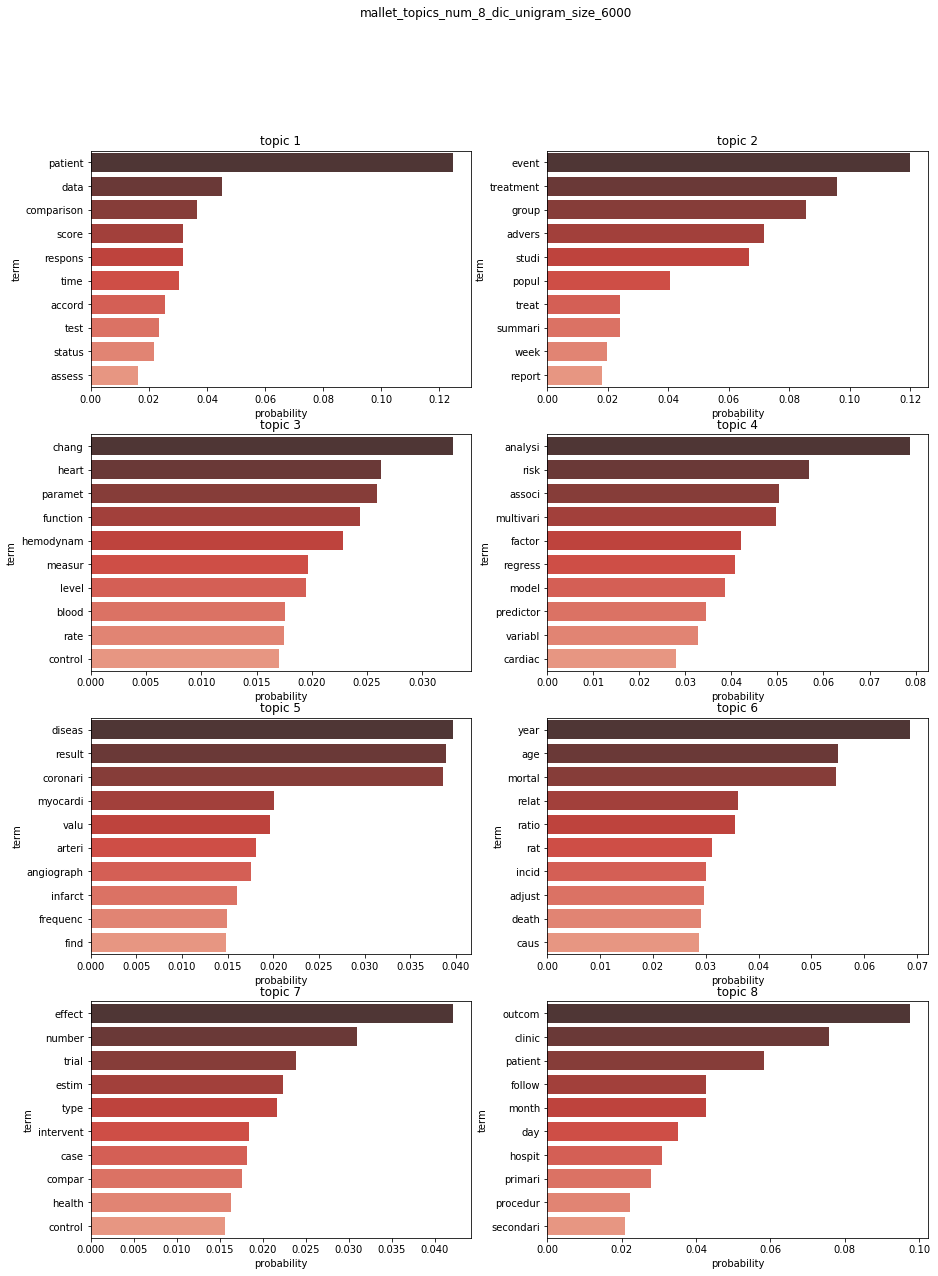

In [31]:
max_coherence_topic_num = 8
# max_coherence_topic_num_on = 8
# max_coherence_topic_num_tfidf = 8

mallet_model = get_optimal_model('mallet', max_coherence_topic_num)
# on_model = get_optimal_model('online', max_coherence_topic_num_on)
# tfidf_model = get_optimal_model('tfidf', max_coherence_topic_num_tfidf)

In [32]:
len(bow_corpus)

32049

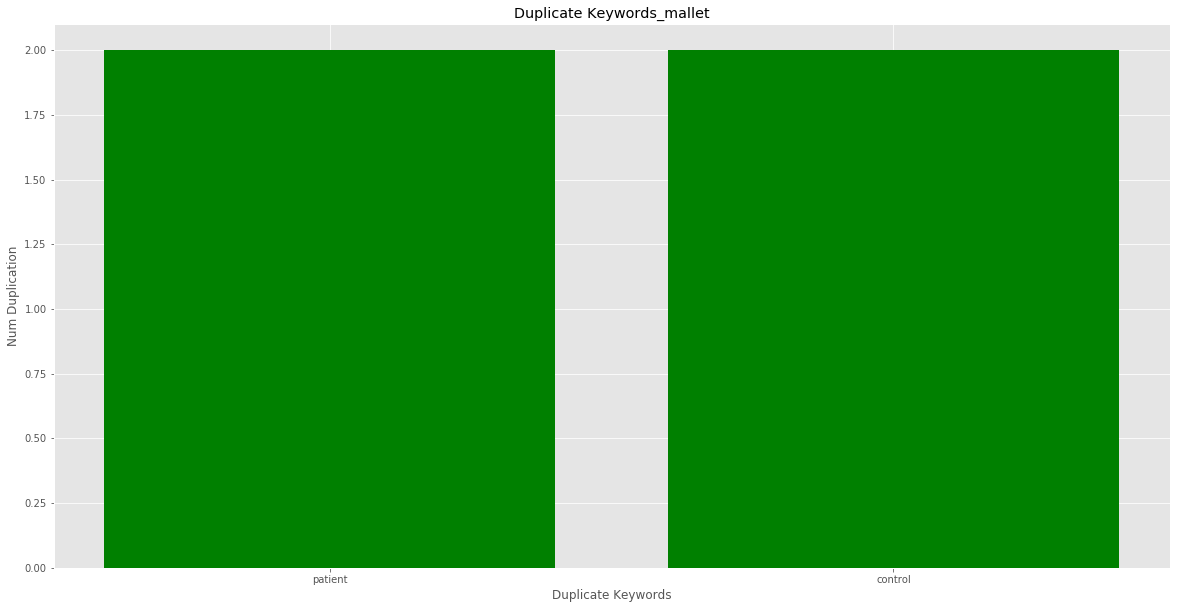

In [33]:
import operator 

def draw_duplicate_keywords_bar(model_type, optimal_topic_num, duplicate_keywords):
    plt.style.use('ggplot')

    x = duplicate_keywords.keys()
    x_values = [item[1] for item in duplicate_keywords.items()]
    x_pos = [i for i in range(len(x))]

    fig = plt.figure(figsize=(20,10))
    plt.bar(x_pos, x_values, color='green')
    plt.xlabel("Duplicate Keywords")
    plt.ylabel("Num Duplication")
    plt.title("Duplicate Keywords_" + model_type)

    plt.xticks(x_pos, x)
    plt.show()
    fig.savefig(directory+'/'+model_type+'_duplicate_keywords'+str(optimal_topic_num)+'.png')
    
def check_duplicate_keywords(model_type, optimal_topic_num, topics):
    all_keywords = {}
    for topic in topics:
        for t in topic[1]:
            keyword = t[0]
            if keyword in all_keywords.keys():
                all_keywords[keyword] = all_keywords[keyword] + 1
            else:
                all_keywords[keyword] = 1
    
    duplicates= dict(filter(lambda x: x[1] > 1, \
           sorted(all_keywords.items(), key=operator.itemgetter(1), reverse=True)))
    draw_duplicate_keywords_bar(model_type, optimal_topic_num, duplicates)
    return duplicates


duplicate_keywords_mallet = check_duplicate_keywords("mallet", max_coherence_topic_num, mallet_model.show_topics(formatted=False))
# duplicate_keywords_on = check_duplicate_keywords("online", max_coherence_topic_num_on, on_model.show_topics(formatted=False))
# duplicate_keywords_tfidf = check_duplicate_keywords("tfidf", max_coherence_topic_num_tfidf, tfidf_model.show_topics(formatted=False))

In [34]:
def get_unique_keywords(model_type, topics, duplicate_keywords):
#     print(list(map(lambda x: x[1][0], topics)))
#     for t in topics:
#         print(list(map(lambda x: x[0], t[1])))
#     print('=================')
    keyword_df = pd.DataFrame(list(map(lambda s: [s[0], list(map(lambda x: x[0], s[1]))], \
                                 topics)))
    keyword_df.columns = ['topic', 'keywords']
    duplicate_removed = []
    for indx, row in keyword_df.iterrows():
        duplicate_removed.append(list(filter(lambda x: x not in duplicate_keywords, row.keywords)))

    keyword_df['unique_keywords'] = pd.Series(duplicate_removed, index=keyword_df.index)
    print(keyword_df)
    keyword_df.to_html(directory+'/'+model_type+'_unique_keywords.html', index=False)
    
get_unique_keywords("mallet", mallet_model.show_topics(formatted=False), duplicate_keywords_mallet)
# get_unique_keywords("online", on_model.show_topics(formatted=False), duplicate_keywords_on)
# get_unique_keywords("tfidf", tfidf_model.show_topics(formatted=False), duplicate_keywords_tfidf)

   topic  \
0  0       
1  1       
2  2       
3  3       
4  4       
5  5       
6  6       
7  7       

                                                                                  keywords  \
0  [patient, data, comparison, score, respons, time, accord, test, status, assess]           
1  [event, treatment, group, advers, studi, popul, treat, summari, week, report]             
2  [chang, heart, paramet, function, hemodynam, measur, level, blood, rate, control]         
3  [analysi, risk, associ, multivari, factor, regress, model, predictor, variabl, cardiac]   
4  [diseas, result, coronari, myocardi, valu, arteri, angiograph, infarct, frequenc, find]   
5  [year, age, mortal, relat, ratio, rat, incid, adjust, death, caus]                        
6  [effect, number, trial, estim, type, intervent, case, compar, health, control]            
7  [outcom, clinic, patient, follow, month, day, hospit, primari, procedur, secondari]       

                                            

In [35]:
# #Check topic distribution of a sample data
# for ind, score in sorted(lda_mallet[bow_corpus[45]], key=lambda x: -1*x[1]):
#     print('\nScore: {}\t \nTopic: {}'.format(score, lda_mallet.print_topic(ind, 10)))

In [36]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [37]:
import gzip
import os

dataDir = directory+'/data/'

def extract_params(statefile):
    """extract alpha and beta values from MALLET statefile by path to statfile
    
    Args:
        statefile (str) : Path to statefile produced by MALLET
    Returns:
        tuple: alpha (list), beta
    """
    
#     with codecs.open(statefile, "r",encoding='utf-8') as state:
    with gzip.open(statefile, 'r') as state:
        params = [x.decode('utf-8').strip() for x in state.readlines()[1:3]]
#         params = [x.strip() for x in state.readlines()[1:3]]
    return (list(params[0].split(':')[1].split(" ")), float(params[1].split(':')[1]))

def state_to_df(statefile):
    """transform state file into pandas dataframe
    the MALLET statefile is tab-separated, and the first two rows contain the alpha and beta parameters
    
    Args:
        statefile (str): Path to statefile produced by MALLET
    Returns:
        dataframe: topic assignment for each token in each documnet of the model
    """
    return pd.read_csv(statefile,\
                      compression='gzip',\
                      sep=' ',\
                      skiprows=[1,2])

In [38]:
params = extract_params(os.path.join(dataDir, 'state.mallet.gz'))
alpha = [float(x) for x in params[0][1:]]
beta = params[1]
print("{}, {}".format(alpha, beta))

[6.25, 6.25, 6.25, 6.25, 6.25, 6.25, 6.25, 6.25], 0.01


In [39]:
df = state_to_df(os.path.join(dataDir, 'state.mallet.gz'))
df['type'] = df.type.astype(str)
df[:5]
#doc id, word position index, word index, topic assignmnet

,#doc,source,pos,typeindex,type,topic
0,0,NaN,0,0,analysi,3
1,0,NaN,1,1,efficaci,1
2,1,NaN,0,2,ca,2
3,1,NaN,1,3,comparison,0
4,1,NaN,2,4,level,2


In [40]:
#to get the length of the document, group by the document id and count the tokens
docs = df.groupby('#doc')['type'].count().reset_index(name='doc_length')
docs[:10]

#get vocab and term frequencies
vocab = df['type'].value_counts().reset_index()
vocab.columns = ['type', 'term_freq']
vocab = vocab.sort_values(by='type', ascending=True)
vocab[:5]

,#doc,doc_length
0,0,2
1,1,6
2,2,3
3,3,4
4,4,3
5,5,2
6,6,5
7,7,8
8,8,5
9,9,2


,type,term_freq
3973,aa,4
2301,aaa,9
4555,aac,3
3109,aad,5
3599,aav,4


In [41]:
docs.shape

(32042, 2)

In [42]:
#matrix file
#need to normalize data so that each row sums to 1
import sklearn.preprocessing

def pivot_and_smooth(df, smooth_values, rows_variable, cols_variable, values_variable):
    """
    modify dataframe into matrix
    Args:
        df (dataframe) : 
        smooth_values (float) : value to add to the matrix to account for the priors
        rows_variable (str) : title of rows
        cols_variable (str) : title of columns
        values_variable (str) : values
    Returns:
        dataframe : that has been normalized on the rows.
    """
    matrix = df.pivot(index=rows_variable, columns=cols_variable, values=values_variable).fillna(value=0)
    matrix = matrix.values + smooth_values
    
    normed = sklearn.preprocessing.normalize(matrix, norm='l1', axis=1)
    
    return pd.DataFrame(normed)

In [43]:
#get the number of topic assingments for words in documents
#phi - topic-term matrix and counted the number of times each word was assigned to each topic 
#and sorted by alphabetically to match the order of the vocabulary frame

#beta as the smoothign value
phi_df = df.groupby(['topic', 'type'])['type'].count().reset_index(name='token_count')
phi_df = phi_df.sort_values(by='type', ascending=True)
phi_df[:5]

phi = pivot_and_smooth(phi_df, beta, 'topic', 'type', 'token_count')
phi[:5]

#theta document-topic matrix and use alpha as the smoothign value
theta_df = df.groupby(['#doc', 'topic'])['topic'].count().reset_index(name='topic_count')
theta_df[:5]

theta = pivot_and_smooth(theta_df, alpha, '#doc', 'topic', 'topic_count')
theta[:5]

,topic,type,token_count
1105,1,aa,3
6811,7,aa,1
4796,5,aaa,9
2934,3,aac,3
2935,3,aad,5


,0,1,2,3,4,5,6,7,8,9,...,5939,5940,5941,5942,5943,5944,5945,5946,5947,5948
0,3.616703e-07,3.616703e-07,3.616703e-07,3.616703e-07,3.616703e-07,3.616703e-07,3.616703e-07,3.652870e-05,3.616703e-07,3.616703e-07,...,3.616703e-07,3.616703e-07,3.616703e-07,7.269574e-05,3.616703e-07,3.616703e-07,3.616703e-07,3.616703e-07,3.616703e-07,3.616703e-07
1,1.050813e-04,3.491073e-07,3.491073e-07,3.491073e-07,1.399920e-04,3.491073e-07,3.491073e-07,3.525984e-05,3.491073e-07,3.491073e-07,...,3.491073e-07,3.491073e-07,3.491073e-07,3.491073e-07,3.491073e-07,1.749027e-04,3.491073e-07,3.491073e-07,3.491073e-07,3.491073e-07
2,3.385987e-07,3.385987e-07,3.385987e-07,3.385987e-07,3.385987e-07,3.385987e-07,3.385987e-07,3.385987e-07,1.696379e-04,3.385987e-07,...,3.385987e-07,6.805833e-05,3.385987e-07,3.385987e-07,1.117714e-03,3.385987e-07,1.357781e-04,7.113958e-04,3.385987e-07,3.385987e-07
3,3.417928e-07,3.417928e-07,1.028796e-04,1.712382e-04,3.417928e-07,3.417928e-07,3.417928e-07,3.417928e-07,3.417928e-07,3.763139e-04,...,3.417928e-07,3.417928e-07,3.417928e-07,3.417928e-07,3.417928e-07,3.417928e-07,3.417928e-07,3.417928e-07,3.417928e-07,3.417928e-07
4,3.477113e-07,3.477113e-07,3.477113e-07,3.477113e-07,3.477113e-07,3.477113e-07,3.477113e-07,3.477113e-07,3.477113e-07,3.477113e-07,...,3.477113e-07,3.477113e-07,3.477113e-07,3.477113e-07,6.988997e-05,3.477113e-07,3.477113e-07,3.477113e-07,3.477113e-07,2.089745e-04


,#doc,topic,topic_count
0,0,1,1
1,0,3,1
2,1,0,1
3,1,2,2
4,1,3,1


,0,1,2,3,4,5,6,7
0,0.120192,0.139423,0.120192,0.139423,0.120192,0.120192,0.120192,0.120192
1,0.129464,0.111607,0.147321,0.129464,0.111607,0.111607,0.129464,0.129464
2,0.136792,0.117925,0.117925,0.136792,0.136792,0.117925,0.117925,0.117925
3,0.115741,0.189815,0.115741,0.115741,0.115741,0.115741,0.115741,0.115741
4,0.117925,0.136792,0.155660,0.117925,0.117925,0.117925,0.117925,0.117925


In [44]:
len(df['#doc'].unique())

32042

In [45]:
lda_mallet_data = {
    'topic_term_dists':phi,
    'doc_topic_dists':theta,
    'doc_lengths':list(docs['doc_length']),
    'vocab':list(vocab['type']),
    'term_frequency':list(vocab['term_freq'])
}

mallet_vis_data = pyLDAvis.prepare(**lda_mallet_data)
pyLDAvis.display(mallet_vis_data)
pyLDAvis.save_html(mallet_vis_data, directory+'/mallet_topics_num_'+str(max_coherence_topic_num)+'.html')

In [46]:
# #each bubble = topic, the larger the bubble, the more prevalent is that topic
# #good topic = fairly big, non-overlapping bubbles scattered throughout the chart
# #model with too many topics = typically have many overlaps, small sized bubbles in one region of the chart
# data_tfidf = pyLDAvis.gensim.prepare(tfidf_model, tfidf_corpus, dictionary)
# data_tfidf

# #bar = salient keywords that form the selected topic
# pyLDAvis.display(data_tfidf)
# pyLDAvis.save_html(data_tfidf, directory+'/tfidf_topics_num_'+str(max_coherence_topic_num_tfidf)+'.html')

# data_on = pyLDAvis.gensim.prepare(on_model, bow_corpus, dictionary)
# data_on

# pyLDAvis.display(data_on)
# pyLDAvis.save_html(data_on, directory+'/online_topics_num_'+str(max_coherence_topic_num_on)+'.html')

#### Perplexity and Coherence score
- model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is

In [47]:
#compute perplexity : a measure of how good the model is
# lower the better
# print('\nPerplexit: ', lda_mallet.log_perplexity(bow_corpus))
# print('\nPerplexit: ', lda_model_tfidf.log_perplexity(bow_corpus))

In [48]:
from gensim.models import CoherenceModel

#compute coherence score
coherence_model_lda = CoherenceModel(model=mallet_model, texts=dictionary_made_by, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# #compute coherence score
# coherence_model_lda_tfidf = CoherenceModel(model=tfidf_model, texts=processed_trigram, dictionary=dictionary, coherence='c_v')
# coherence_lda_tfidf = coherence_model_lda_tfidf.get_coherence()
# print('\nTF-IDF Coherence Score: ', coherence_lda_tfidf)

# #compute coherence score
# coherence_model_lda_on = CoherenceModel(model=on_model, texts=processed_trigram, dictionary=dictionary, coherence='c_v')
# coherence_lda_on = coherence_model_lda_on.get_coherence()
# print('\nONLINE Coherence Score: ', coherence_lda_on)


Coherence Score:  0.4431081261849146


### Find dominant topic
- find the most contributed topic

In [49]:
processed_docs = processed_docs.merge(documents, on='id')
# test = processed_docs[['id', 'title_x', 'bow_corpus', 'title_y']]
# test.to_csv('test.csv')

In [50]:
processed_docs.shape

(32049, 5)

In [51]:
processed_docs.head(5)

,id,title_x,bow_corpus,index,title_y
0,4106,"[analysi, efficaci]","[(0, 1), (1, 1)]",0,Analysis of efficacy
1,4107,"[comparison, postop, ca, level, surviv, espac, conoko, jaspac, trial]","[(2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]",1,Comparisons of postoperative CA19-9 levels on survival of ESPAC-4 with the CONOKO-01 and JASPAC-1 trials
2,4108,"[pattern, diseas, relaps]","[(8, 1), (9, 1), (10, 1)]",2,Pattern of disease relapse
3,4109,"[grade, advers, event, gemcitabin, gemcitabin, plus, capecitabin]","[(11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]",3,Grade 1–5 adverse events with gemcitabine alone and gemcitabine plus capecitabine
4,4112,"[treatment, zoledron, acid]","[(16, 1), (17, 1), (18, 1)]",4,Treatment with zoledronic acid


In [52]:
processed_docs.iloc[151]

id            4325                                     
title_x       [current, patient, status, follow]       
bow_corpus    [(101, 1), (178, 1), (262, 1), (456, 1)] 
index         151                                      
title_y       Current Patient Status at Last Follow-up 
Name: 151, dtype: object

In [53]:
import random

def format_topics_sentences(model, \
                            model_type='mallet', \
                            corpus=processed_docs, \
                            texts=dictionary_made_by):
    sent_topic_df = pd.DataFrame()
    if model_type=='tfidf':
        target_corpus = corpus.tfidf_corpus
    else:
        target_corpus = corpus.bow_corpus
    
    for i, row in enumerate(model[target_corpus]):
        origin_info = processed_docs.iloc[i]
        text_vec = texts[i]
        #get main topic in each document
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0: #dominant topic
                wp = model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
#                 print(pd.Series([origin_info.id,\
#                                 int(topic_num), \
#                                 round(prop_topic, 4), \
#                                 topic_keywords, \
#                                origin_info.title_y, \
#                                text_vec]))
                sent_topic_df = sent_topic_df.append(pd.Series([origin_info.id,\
                                                                int(topic_num), \
                                                                round(prop_topic, 4), \
                                                                topic_keywords, \
                                                               origin_info.title_y, \
                                                               text_vec]), ignore_index=True)
            else:
                break
    sent_topic_df.columns = ['id', 'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Origin_Text', 'Text_Vec']
    
    return (sent_topic_df)

In [54]:
df_topic_sents_keywords_mallet = format_topics_sentences(model=mallet_model, \
                                                  corpus=processed_docs, \
                                                  texts=dictionary_made_by, \
                                                 model_type='mallet')
df_topic_sents_keywords_mallet.head(max_coherence_topic_num)

,id,Dominant_Topic,Perc_Contribution,Topic_Keywords,Origin_Text,Text_Vec
0,4106,1.0,0.1394,"event, treatment, group, advers, studi, popul, treat, summari, week, report",Analysis of efficacy,"[analysi, efficaci]"
1,4107,2.0,0.1473,"chang, heart, paramet, function, hemodynam, measur, level, blood, rate, control",Comparisons of postoperative CA19-9 levels on survival of ESPAC-4 with the CONOKO-01 and JASPAC-1 trials,"[comparison, postop, ca, level, surviv, espac, conoko, jaspac, trial]"
2,4108,0.0,0.1368,"patient, data, comparison, score, respons, time, accord, test, status, assess",Pattern of disease relapse,"[pattern, diseas, relaps]"
3,4109,1.0,0.1898,"event, treatment, group, advers, studi, popul, treat, summari, week, report",Grade 1–5 adverse events with gemcitabine alone and gemcitabine plus capecitabine,"[grade, advers, event, gemcitabin, gemcitabin, plus, capecitabin]"
4,4112,2.0,0.1515,"chang, heart, paramet, function, hemodynam, measur, level, blood, rate, control",Treatment with zoledronic acid,"[treatment, zoledron, acid]"
5,4113,1.0,0.1394,"event, treatment, group, advers, studi, popul, treat, summari, week, report",Treatment with docetaxel,"[treatment, docetaxel]"
6,4114,1.0,0.1500,"event, treatment, group, advers, studi, popul, treat, summari, week, report","Treatments ever used at relapse, at the discretion of the treating clinician","[treatment, relaps, discret, treat, clinician]"
7,4115,1.0,0.2112,"event, treatment, group, advers, studi, popul, treat, summari, week, report",Worst adverse event (grade) reported over entire time on trial,"[worst, advers, event, grade, report, entir, time, trial]"


In [55]:
df_topic_sents_keywords_mallet.shape

(32049, 6)

In [56]:
# df_topic_sents_keywords_tfidf = format_topics_sentences(model=tfidf_model, \
#                                                   corpus=processed_docs, \
#                                                   texts=dictionary_made_by, \
#                                                  model_type='tfidf')
# df_topic_sents_keywords_tfidf.head(max_coherence_topic_num_tfidf)

In [57]:
# df_topic_sents_keywords_on = format_topics_sentences(model=on_model, \
#                                                   corpus=processed_docs, \
#                                                   texts=dictionary_made_by, \
#                                                  model_type='online')
# df_topic_sents_keywords_on.head(max_coherence_topic_num_on)

In [58]:
print(df_topic_sents_keywords_mallet.isna().any())
print('=================')
# print(df_topic_sents_keywords_tfidf.isna().any())
# print('=================')
# print(df_topic_sents_keywords_on.isna().any())

id                   False
Dominant_Topic       False
Perc_Contribution    False
Topic_Keywords       False
Origin_Text          False
Text_Vec             False
dtype: bool


#### 각 토픽별로 가장 대표적인 문서 찾기

In [59]:
def get_rep_sents(keywords, model_type):
    sent_topics_sorted_df_mallet = pd.DataFrame()
    
    sent_topics_groupby = keywords.groupby('Dominant_Topic')

    keywords_top = pd.DataFrame()
    for i, grp in sent_topics_groupby:
        keywords_top = pd.concat([keywords_top, \
                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(50)], \
                            axis=0)
        keywords = pd.concat([keywords, \
                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(50)], \
                            axis=0)

    keywords_top.reset_index(drop=True, inplace=True)
    keywords_top.columns = ['id', 'Topic_Num', 'Topic_Perc_Contribu', 'Topic_Keywords', 'Origin_Text', 'Text']
    keywords_top.to_csv(directory+'/'+model_type+'_top_sen.tsv', sep='\t')
    
    keywords.reset_index(drop=True, inplace=True)
    keywords.columns = ['id', 'Topic_Num', 'Topic_Perc_Contribu', 'Topic_Keywords', 'Origin_Text', 'Text']
    
    return keywords
    
df_topic_sents_mallet = get_rep_sents(df_topic_sents_keywords_mallet, 'mallet')
# df_topic_sents_tfidf = get_rep_sents(df_topic_sents_keywords_tfidf, 'tfidf')
# df_topic_sents_on = get_rep_sents(df_topic_sents_keywords_on, 'online')

In [60]:
df_topic_sents_mallet.shape

(32449, 6)

In [61]:
df_topic_sents_mallet.drop_duplicates(subset=['id'], inplace=True)

In [62]:
df_topic_sents_mallet.shape

(32049, 6)

In [64]:
from db_conn import get_connection

# conn = get_connection()
# conn.set_client_encoding('UTF8')


def update_topic_num(keyword_df):
    _cur = conn.cursor()
    update_sql = """UPDATE article_tables
                    SET topic_num_title = %s,
                    topic_num_title_perc = %s
                    WHERE
                     id=%s"""
    
    for row in keyword_df.iterrows():
        _id = row[1]['id']
        topic_num = row[1]['Topic_Num']
#         print(topic_num)
        perc = row[1]['Topic_Perc_Contribu']
#         print(perc)
        _cur.execute(update_sql, (topic_num, perc, _id, ))
        conn.commit()

In [65]:
# 전체 문서 찾기

sent_topics_sorted_df_mallet = pd.DataFrame()

sent_topics_groupby = df_topic_sents_keywords_mallet.groupby('Dominant_Topic')

for i, grp in sent_topics_groupby:
    keywords = pd.concat([df_topic_sents_keywords_mallet, \
                         grp.sort_values(['Perc_Contribution'], ascending=[0])], \
                        axis=0)

keywords.reset_index(drop=True, inplace=True)
keywords.columns = ['id', 'Topic_Num', 'Topic_Perc_Contribu', 'Topic_Keywords', 'Origin_Text', 'Text']

keywords.head()

,id,Topic_Num,Topic_Perc_Contribu,Topic_Keywords,Origin_Text,Text
0,4106,1.0,0.1394,"event, treatment, group, advers, studi, popul, treat, summari, week, report",Analysis of efficacy,"[analysi, efficaci]"
1,4107,2.0,0.1473,"chang, heart, paramet, function, hemodynam, measur, level, blood, rate, control",Comparisons of postoperative CA19-9 levels on survival of ESPAC-4 with the CONOKO-01 and JASPAC-1 trials,"[comparison, postop, ca, level, surviv, espac, conoko, jaspac, trial]"
2,4108,0.0,0.1368,"patient, data, comparison, score, respons, time, accord, test, status, assess",Pattern of disease relapse,"[pattern, diseas, relaps]"
3,4109,1.0,0.1898,"event, treatment, group, advers, studi, popul, treat, summari, week, report",Grade 1–5 adverse events with gemcitabine alone and gemcitabine plus capecitabine,"[grade, advers, event, gemcitabin, gemcitabin, plus, capecitabin]"
4,4112,2.0,0.1515,"chang, heart, paramet, function, hemodynam, measur, level, blood, rate, control",Treatment with zoledronic acid,"[treatment, zoledron, acid]"


In [66]:
# update 할때만 주석 해제
# update_topic_num(keywords)

In [67]:
df_topic_sents_keywords_mallet.head(5)

,id,Dominant_Topic,Perc_Contribution,Topic_Keywords,Origin_Text,Text_Vec
0,4106,1.0,0.1394,"event, treatment, group, advers, studi, popul, treat, summari, week, report",Analysis of efficacy,"[analysi, efficaci]"
1,4107,2.0,0.1473,"chang, heart, paramet, function, hemodynam, measur, level, blood, rate, control",Comparisons of postoperative CA19-9 levels on survival of ESPAC-4 with the CONOKO-01 and JASPAC-1 trials,"[comparison, postop, ca, level, surviv, espac, conoko, jaspac, trial]"
2,4108,0.0,0.1368,"patient, data, comparison, score, respons, time, accord, test, status, assess",Pattern of disease relapse,"[pattern, diseas, relaps]"
3,4109,1.0,0.1898,"event, treatment, group, advers, studi, popul, treat, summari, week, report",Grade 1–5 adverse events with gemcitabine alone and gemcitabine plus capecitabine,"[grade, advers, event, gemcitabin, gemcitabin, plus, capecitabin]"
4,4112,2.0,0.1515,"chang, heart, paramet, function, hemodynam, measur, level, blood, rate, control",Treatment with zoledronic acid,"[treatment, zoledron, acid]"


In [68]:
df_topic_sents_mallet.head(5)

,id,Topic_Num,Topic_Perc_Contribu,Topic_Keywords,Origin_Text,Text
0,4106,1.0,0.1394,"event, treatment, group, advers, studi, popul, treat, summari, week, report",Analysis of efficacy,"[analysi, efficaci]"
1,4107,2.0,0.1473,"chang, heart, paramet, function, hemodynam, measur, level, blood, rate, control",Comparisons of postoperative CA19-9 levels on survival of ESPAC-4 with the CONOKO-01 and JASPAC-1 trials,"[comparison, postop, ca, level, surviv, espac, conoko, jaspac, trial]"
2,4108,0.0,0.1368,"patient, data, comparison, score, respons, time, accord, test, status, assess",Pattern of disease relapse,"[pattern, diseas, relaps]"
3,4109,1.0,0.1898,"event, treatment, group, advers, studi, popul, treat, summari, week, report",Grade 1–5 adverse events with gemcitabine alone and gemcitabine plus capecitabine,"[grade, advers, event, gemcitabin, gemcitabin, plus, capecitabin]"
4,4112,2.0,0.1515,"chang, heart, paramet, function, hemodynam, measur, level, blood, rate, control",Treatment with zoledronic acid,"[treatment, zoledron, acid]"


In [69]:
df_topic_sents_keywords_mallet.to_csv('./mallet_results.tsv', sep='\t')

In [70]:
df_topic_sents_keywords_mallet.shape

(32049, 6)

#### 문서 전체적인 토픽 분포

In [71]:
topic_counts = df_topic_sents_mallet['Topic_Num'].value_counts()
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

topic_num_keywords = df_topic_sents_mallet[['Topic_Num', 'Topic_Keywords']]

df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)

In [72]:
topic_num_keywords.drop_duplicates(inplace=True)
topic_num_keywords

,Topic_Num,Topic_Keywords
0,1.0,"event, treatment, group, advers, studi, popul, treat, summari, week, report"
1,2.0,"chang, heart, paramet, function, hemodynam, measur, level, blood, rate, control"
2,0.0,"patient, data, comparison, score, respons, time, accord, test, status, assess"
10,6.0,"effect, number, trial, estim, type, intervent, case, compar, health, control"
13,5.0,"year, age, mortal, relat, ratio, rat, incid, adjust, death, caus"
21,7.0,"outcom, clinic, patient, follow, month, day, hospit, primari, procedur, secondari"
38,4.0,"diseas, result, coronari, myocardi, valu, arteri, angiograph, infarct, frequenc, find"
50,3.0,"analysi, risk, associ, multivari, factor, regress, model, predictor, variabl, cardiac"


In [73]:
df_dominant_topics.reset_index(level=0, inplace=True)
df_dominant_topics.columns = ['Topic_Num', 'Num_Documents', 'Perc_Documents']
df_dominant_topics = df_dominant_topics.merge(topic_num_keywords, on='Topic_Num')
df_dominant_topics = df_dominant_topics.sort_values('Topic_Num')

df_dominant_topics.reset_index(drop = True, inplace = True)
df_dominant_topics.to_html(directory+'/mallet_distribution.html', index=False)
df_dominant_topics.head(max_coherence_topic_num)

,Topic_Num,Num_Documents,Perc_Documents,Topic_Keywords
0,0.0,4207,0.1313,"patient, data, comparison, score, respons, time, accord, test, status, assess"
1,1.0,4892,0.1526,"event, treatment, group, advers, studi, popul, treat, summari, week, report"
2,2.0,4350,0.1357,"chang, heart, paramet, function, hemodynam, measur, level, blood, rate, control"
3,3.0,4117,0.1285,"analysi, risk, associ, multivari, factor, regress, model, predictor, variabl, cardiac"
4,4.0,3769,0.1176,"diseas, result, coronari, myocardi, valu, arteri, angiograph, infarct, frequenc, find"
5,5.0,3416,0.1066,"year, age, mortal, relat, ratio, rat, incid, adjust, death, caus"
6,6.0,3175,0.0991,"effect, number, trial, estim, type, intervent, case, compar, health, control"
7,7.0,4123,0.1286,"outcom, clinic, patient, follow, month, day, hospit, primari, procedur, secondari"


In [74]:
# topic_counts = df_topic_sents_tfidf['Topic_Num'].value_counts()
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# topic_num_keywords = df_topic_sents_tfidf[['Topic_Num', 'Topic_Keywords']]

# df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)
# df_dominant_topics.reset_index(level=0, inplace=True)
# df_dominant_topics.columns = ['Topic_Num', 'Num_Documents', 'Perc_Documents']
# df_dominant_topics = df_dominant_topics.merge(topic_num_keywords.drop_duplicates(), on='Topic_Num')
# df_dominant_topics = df_dominant_topics.sort_values('Topic_Num')

# df_dominant_topics.reset_index(drop = True, inplace = True)
# df_dominant_topics.to_html(directory+'/tfidf_distribution.html', index=False)
# df_dominant_topics.head(max_coherence_topic_num)

In [75]:
# topic_counts = df_topic_sents_on['Topic_Num'].value_counts()
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# topic_num_keywords = df_topic_sents_on[['Topic_Num', 'Topic_Keywords']]

# df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)
# df_dominant_topics.reset_index(level=0, inplace=True)
# df_dominant_topics.columns = ['Topic_Num', 'Num_Documents', 'Perc_Documents']
# df_dominant_topics = df_dominant_topics.merge(topic_num_keywords.drop_duplicates(), on='Topic_Num')
# df_dominant_topics = df_dominant_topics.sort_values('Topic_Num')

# df_dominant_topics.reset_index(drop = True, inplace = True)
# df_dominant_topics.to_html(directory+'/on_distribution.html', index=False)
# df_dominant_topics.head(max_coherence_topic_num)

In [76]:
theta.shape

(32042, 8)

In [77]:
import pickle
import gensim    

# model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_model)
output = open('../data/output/lda.pkl', 'wb')
# pickle.dump({'topic_model': model, 
#               'corpus': bow_corpus, 
#               'dictionary': dictionary
#             }, output)
pickle.dump({
            'topic_term_dists':phi,
            'doc_topic_dists':theta,
            'doc_lengths':list(docs['doc_length']),
            'vocab':list(vocab['type']),
            'term_frequency':list(vocab['term_freq'])
        }, output)
output.close()

# topic_term_dists = lda_results['topic_term_dists']
# doc_topic_dists = lda_results['doc_topic_dists']
# doc_lengths = lda_results['doc_lengths']
# vocab = lda_results['vocab']
# term_frequency = lda_results['term_frequency']

# saved_model['lda_result'] = {
#         'document_topic_counts':topic_term_dists,
#         'topic_word_counts':doc_topic_dists,
#         'topic_counts':doc_lengths,
#         'document_lengths':vocab,
#         'distinct_words':term_frequency
#         }

- https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

- https://ai.googleblog.com/2016/12/open-sourcing-embedding-projector-tool.html
- http://projector.tensorflow.org/
- http://nbviewer.jupyter.org/github/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb#loading

In [ ]:
processed_docs.title_y.to_csv('../data/output/origin_text.tsv', sep='\t')

In [ ]:
processed_docs.title_x.to_csv('../data/output/processed.tsv', sep='\t')